# Solution to Q. 4 of the screening questions:
#### 
# A VQE code for arbitraty 'Hermitian' 4x4 matrices
#### 

I am adding to the original task, which asked to solve for a simple matrix, by generalizing the task to any Hermitian matrix, with emphasis on ```Hermiticity``` to ensure a full set of ```REAL``` eigenvalues.

## PLEASE APPLY THE CELLS IN ORDER

## Aim of this code:
Our goal is to find the lowest eigenvalue of a given matrix. In terms of quantum hardware, this translates to the lowest energy $E_0$ of some Hamiltonian.
### 
## Steps:
#### 
### Quantum Part:
#### 
1. Translating the matrix into a qubit operator making it accessible to our quantum hardware
#### 
2. The quantum Bulding the ansatz circuit with some controllable parameters, which generates a tunable trial wavefunction on which we can apply our given qubit operator as a Hamiltonian. The ansatz circuit needs to be flexible enough to gain access to most of the N-qubit (in this case 2 qubit) Hilbert state space.
#### 
3. Measuring the expectation value of every pauli product term in the qubit operator (representing the Hamiltonian). This yields the energy of every term in the Hamiltonian, and we add them all up to generate the energy of the given trial state (ansatz) which we setup using a unique list of parameters.
#### 
### 

### Classical Part:
1. Fine tune the ansatz circuit to find the lowest possible energy of this Hamiltonian. This is the classical optimization part, and is achievable through classical optimization techniques aimed at fine tuning the parameters of the ansatz. This step generates a modified ansatz circuit bringing us a step closer to the optimized trial wavefunction which approximates the ground state of the Hamiltonian.
### 
2. Compare to exact value by solving using classical eigensolver
#### 
On obtainig the ground state energy, we have ourselves the lowest eigenvalue of the Hamiltonian, which corresponds to the lowest eigenvalue of its matrix. 


#### ```an Optional read ```: (some extra insight into the potential usefullness of a more specialized version of this code in quantum chemistry):
### 

This matrix could be a representation of some Hamiltonian of a physical system mapped to a representation which is compatible with quantum hardware. For example, In chemistry this matrix could resemble a physical system's Hamiltonian adjusted by second quantization into a ```Fock space```, where it can then be mapped to a fermionic operator, composed entirely of zeros and ones. This creates an occupational number (ON) basis with their own creation and annihilation operators, where everything is in zeros and ones, making it ideal for mapping onto a qubit based system.
#### 
If we recall that the Hamiltonian matrix elements are simply representations of some physical parameters of a molecular system which contribute to energy (for example bond length in spacial coordinates of some molecule), then extracting the lowest eigenvalue will translate to targeting the lowest energy of the phsyical system.
#### 


In [5]:
## importing some useful packages including ready definitions and arrays for pauli operators

from qiskit import *
import numpy as np
from IPython.display import Math
from numpy import kron

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.extensions import RXGate, XGate, CXGate, RYGate
from qiskit.quantum_info import Statevector


## STEP 1: Getting the qubit operator from a matrix
### 

We are given in the task a single matrix, I will expand the task to ANY Hermitian matrix and will therefore apply this code to 3 different matrices and the reader is free to try out others. The three matrices I will be using are:


In [6]:

################################ ORIGINAL TASK MATRIX ##############################

Hami_1 = np.array([
    [1,0,0,0],
    [0,0,-1,0],
    [0,-1,0,0],
    [0,0,0,1]
])


#################################### EXTRA EXAMPLE 1 ###############################

Hami_2 = np.array([
    [1,4,3,6],
    [4,0,-8,0],
    [3,-8,0,3],
    [6,0,3,1]
])

################################### EXTRA EXAMPLE 2 ################################

Hami_3 = np.array([
    [1,4j,3,6+2j],
    [-4j,0,-8,0],
    [3,-8,0,3],
    [6-2j,0,3,1]
])




#### Now given the Hamiltonian / matrix, we must map it to a Qubit Operator
### 

This step entails we expand our matrix into a sum of Pauli string, which are all comprised of valid qubit operators, and therefore compatible with our quantum hardware.

Our Pauli string terms will be composed of a kroneker product of two (2x2) operators. We know this is possible since we can always represent any hermitian operator of any size as a sum of some product of single and double qubit operators, a proof given in <a href="https://journals.aps.org/pra/abstract/10.1103/PhysRevA.51.1015">this paper</a>. There are seveeral ways to do this, I chose to code for my own ```pauli string decomposition```.
### 
Since we are given a (4x4) Hermitian matrix, we can immediately look to write it as a sum of tensor products of two pauli matrices $\sigma_i \sigma_j$, with coefficients $a_{ij}$  giving:
### 

$$H = \sum_{i,j=1,x,y,z} a_{ij} (\sigma_i^{(2)} \otimes\sigma_j^{(1)})\hspace{1cm}(1)  \hspace{25cm}\
\\ a_{ij} = \frac{1}{4} Tr[(\sigma_i^{(2)} \otimes\sigma_j^{(1)})H]\hspace{1cm}(2) $$

### 
Now to apply this in code


#### Code for mapping the matrix to a Qubit Operator

In [8]:
####################################################################################

##*** this is a dictionary containing all the 16 permutations of our 2-qubit pauli product terms.
# the permutations are formed of the single qubit pauli operators I,X,Y and Z, which form a basis for
# any hermitian 2x2 matrix, so the permutations of their kroneker product form a basis for any
# 2-qubit operator , and in turn 4x4 hermitian matrix  ***##


pauli_dict = {

    "II" : Operator(Pauli(label='II')),
    "XX" : Operator(Pauli(label='XX')),
    "YY" : Operator(Pauli(label='YY')),
    "ZZ" : Operator(Pauli(label='ZZ')),

    "XI" : Operator(Pauli(label='XI')),
    "IX" : Operator(Pauli(label='IX')),
    "YI" : Operator(Pauli(label='YI')),
    "IY" : Operator(Pauli(label='IY')),
    "ZI" : Operator(Pauli(label='ZI')),
    "IZ" : Operator(Pauli(label='IZ')),

    "XZ" : Operator(Pauli(label='XZ')),
    "ZX" : Operator(Pauli(label='ZX')),
    "YZ" : Operator(Pauli(label='YZ')),
    "ZY" : Operator(Pauli(label='ZY')),

    "XY" : Operator(Pauli(label='XY')),
    "YX" : Operator(Pauli(label='YX')),
   
}

####################################################################################

## a list of the pauli product operators:
pauli_values_key = list(pauli_dict.values()) 

## a list of the corresponding labels of the pauli product operators ex "XX" "YY" etc. :
pauli_labels_key = list(pauli_dict)  

####################################################################################


####################################################################################

##*** the function IP ----> (Inner product) takes 2 matrices and projects M2 onto the given M1 matrix,we 
# use this to project the given 4x4 hermitian matrix onto the 16 2-qubit pauli product terms ***##

def IP(M1, M2):
    ''' parameters:
    M1 ..... the basis element on which the projection is done
    M2 ..... the given matrix we want to decompose
    '''
    return (np.dot(M1.conjugate().transpose(), M2)).trace()


####################################################################################

## the function q_op ----> (Qubit operator) maps a matrix into 2-qubit pauli strings

def q_op(H):
    ''' parameters:
    H ...... the matrix we want to map to the qubit operator    
    '''   
    ## initializing necessary lists to hold the info on the decomposition:
    ##*** initiating empty lists which will be used later by the qubit operator fucntion "q_op" to 
    # append to the list the operators with non-zero coefficients 
    #(resulting from the matrix decomposition) ***##

    My_Hami_pauli_list = np.zeros(16, dtype=complex)
    
    pauli_string_indices = []  ## the indices (from 1-16) of the 2-qubit operators forming the matrix,
                            # ex. "YY" corresponds to index "2" according to the pauli_dict dictionary 
    
    pauli_string_labels = []  ## list of labels of the pauli prodcut operators from the matrix decomposition

    pauli_string_coefficients = []  ## list of the coefficients of the pauli product terms forming the matrix

    ## a for loop that projects H onto the i'th pauli string per iteration ##    
    for i in range(16):
        ## the projection on the current basis:
        My_Hami_pauli_list[i] = 1/4 * IP(pauli_values_key[i].data, H) 
            
        if My_Hami_pauli_list[i] != 0.0: ## singling out the non zero coefficients and printing them out
            print(My_Hami_pauli_list[i],pauli_labels_key[i])
            pauli_string_indices.append(i)
            pauli_string_labels.append(pauli_labels_key[i])
            pauli_string_coefficients.append(My_Hami_pauli_list[i])
    
    return My_Hami_pauli_list, pauli_string_indices, pauli_string_labels, pauli_string_coefficients 

####################################################################################            


            

In [9]:
####################################################################################

## here we generate the qubit operator by applying the decomposition function q_op on the 1st matrix Hami_1
quantum_operator_1 = q_op(Hami_1)

## Assigning the pauli_string indices, labels and coefficients of the non zero pauli product terms to a lsit

My_Hami_pauli_list = quantum_operator_1[0]
pauli_string_indices = quantum_operator_1[1]
pauli_string_labels = quantum_operator_1[2]
pauli_string_coefficients =quantum_operator_1[3]

## turning the lists into arrays for convenience

pauli_string_indices = np.asarray(pauli_string_indices)
pauli_string_labels = np.asarray(pauli_string_labels)
pauli_string_coefficients = np.asarray(pauli_string_coefficients)

####################################################################################
## the function also prints the non zero pauli product states with corresponding coefficients: 

(0.5+0j) II
(-0.5+0j) XX
(-0.5+0j) YY
(0.5+0j) ZZ


### Mapping the first (GIVEN) Matrix in the task to a Qubit operator :
### 

we find that the decomposition of the first given matrix H into pauli string is :
### 
$$\begin{pmatrix} 1&0&0&0 \\0&0&-1&0\\0&-1&0&0\\0&0&0&1 \end{pmatrix} \ = \ (0.5) II-(0.5) XX-(0.5) YY+(0.5) ZZ
$$
### 


## STEP 2: Preparing the asnatz :
### 

Choosing the ansatz is a delicate skill highly dependent on experience and intuition, so the one I'm using here was suggested in the problem statement itself. If the reader would like a more universal ansatz for a 2 qubit system they could check out the "Hardware ansatz", some with 10 unique parametrizations in them. However as recommended we can start of with the given single paramter ansatz:
### 

In [10]:
##Add some gates to start shaping the initial all zeros qubit state into the given ansatz

'''  Since the ansatz proposed in the question is not universal, I will choose a more encompassing 
pseudo-universal ansatz with just 8 parameters given below, it should be good enough to cover most of the 
2 qubit hilbert space down to acceptable resolution'''

####################################################################################

##### first we define a single qubit ansatz from which we can call to form any number of double qubit ansatz

def Single_Qubit_Ansatz(qc, qubit, angles):
    '''
    function parameters:
    qc...... QuantumCircuit
    qubit_pstn......... qubit's position in qubit register
    angles .... array of anngles
    Applies the neccessary rotation gates for a single qubit ansatz state
    '''
    qc.ry( angles[0], qubit )
    qc.rz( angles[1], qubit )
    
####################################################################################

##### second we define the 2-qubit gates which are simply combinations of 1-qubit gates and entanglers

def Two_Qubit_Ansatz(qc, q, angles):
    
    '''
    parameters:
    qc ..... (QuantumCircuit)
    q ....... (QuantumRegister) 
    params (array) ....  Applies the neccessary rotation on ALL the single qubit rotators'''
    
    Single_Qubit_Ansatz( qc, q[0], [angles[0], angles[1]] )    
    Single_Qubit_Ansatz( qc, q[1], [angles[2], angles[3]] )
    qc.cx( q[0], q[1] )
    Single_Qubit_Ansatz( qc, q[0], [angles[4], angles[5]] )
    Single_Qubit_Ansatz( qc, q[1], [angles[6], angles[7]] )
    
    
####################################################################################  
## this functions generates the requires ansatz:

def Get_Two_Qubit_Circuit(angles):
    '''
    parameters:
    just give the function the 8 angles for generating the ansatz
    '''
    qr = QuantumRegister(2,'q')
    cr = ClassicalRegister(2,'c')
    qc = QuantumCircuit(qr,cr)
    Two_Qubit_Ansatz(qc,qr,angles)
    
    return qc




### An ansatz circuit has 2 main regions besides the framework. 
#### 
A. The ```rotations```, which are given by the ```RX and RY gates``` in this case. Here we have a hardware ansatz with 8 parameters, the ``` 8-angles``` of rotation on the 8-rotation gayes. These are our ```Parametrized single qubit rotations```
#### 
B. The ```entangling region```, which is a lonely ```CX gate``` in our case. It relates the state of the first with the second qubit through entanglment, bringing about quantum effects and allwoing us to have superposition states which gives us access to many more 2-qubit state subspaces, and is crucial for finding the right eigenstate of the hamiltonian matrix with the lowest eigenvalue.
#### 


#### An example of what the ansatz looks like using the "Get_Two_Qubit_Circuit" function above, with angles given as 1-8 for illustration:

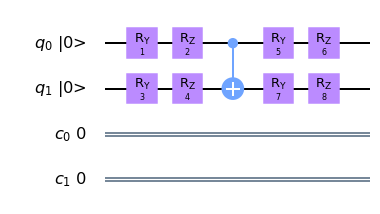

In [11]:

params = np.array([1,2,3,4,5,6,7,8]) ## an array for illustration composed of angles 1-8
aa = Get_Two_Qubit_Circuit(params) ## applying the ansatz circuit generator function on a list of 8 angles

aa.draw(output='mpl',cregbundle=False, initial_state = 'True') ## fucntion that draws the circuit


## STEP 3: Extracting the Expectation values of all the pauli terms from the counts made on repeated measurement on a quantum computer (or in this case a quantum computer simulator):

Each pauli term dictates a certain protocol for getting expectation values from quantum hardware measurements. We are limited to using the Z-basis for measurment since that is what our quantum hardware dictates.For example for the first matrix decomposition the expectation value would be :
#### 

$$\left\langle H \right\rangle = \left\langle \psi \right| H \left| \psi \right\rangle = 0.5 \left\langle \psi \right| II \left| \psi \right\rangle - 0.5 \left\langle \psi \right| XX \left| \psi \right\rangle -0.5 \left\langle \psi \left| YY \right| \psi \right\rangle + 0.5 \left\langle \psi \left| ZZ \right| \psi \right\rangle $$
#### 

This is straightforward to extract given we apply the circuit and do our repeated measurements term by term. For the ZZ operator it's straightforward since it's already in the z-basis. and the state is
#### 

$$ c_1^{ZZ}\left| 00 \right\rangle + c_2^{ZZ}\left| 01 \right\rangle + c_3^{ZZ}\left| 10 \right\rangle + c_4^{ZZ}\left| 11 \right\rangle,$$
#### 

<center> This gives the expectation value of </center>


$$ {|c_1^{ZZ}|}^2 + {|c_2^{ZZ}|}^2 + {|c_3^{ZZ}|}^2 + {|c_4^{ZZ}|}^2$$

####  

This is easy to get from our quantum hardware measurements since these terms are simply the probabilities of getting these states. For example ${|c_1^{ZZ}|}^2$ is the probability of getting state $\left| 00 \right\rangle$ and corresponds to the counts registered in that state during measurment divided by the total counts states. ZI and IZ terms however require a certain pattern for the +/- signs infront of the counts and we will use a function that propagates basis states into a +/- state to extract this info.

#### 

Now for Terms with a single X or Y in their pauli products, getting the counts to represent their expectation values is not straightforward, and we need to apply rotations to that qubit before measurment. any single qubit X term, in the pauli product, will require a Hadamard gate on that qubit before measurement, and any Y term will require a U2 gate at 0 and 90 degrees. this too is accounted fore by another function which forms the measurement circuit by adjusting the ansatz for each case.
#### 



In [12]:

####################################### Function calculating the appropriate +/- sign informt of the counts
# of 00 , 01, 10, 11 given a certain label XX,YY,ZZ,ZI ... etx #####################################

def eigenvalue_array (measurement_label):
    '''
    parameters: 
    measurement_label ........ input XX, YY, IZ ..etc to denote the pauli product term
    provided the labels for the pauli product operator, we divide the 16 available basis terms into 
    3 main protocols, they either follow the ZZ pattern, the IZ pattern or the ZI pattern,
    '''
    if measurement_label in ("II","XX","YY","ZZ","XY","YX","XZ","ZX","YZ","ZY"):
        label = "ZZ"
    elif measurement_label in ("XI","YI","ZI"):
        label = "ZI"
    elif measurement_label in ("IX","IY","IZ"):
        label = "IZ"
    
    evolved00 = Statevector.from_label('00').evolve(pauli_dict[label])
    evolved01 = Statevector.from_label('01').evolve(pauli_dict[label])
    evolved10 = Statevector.from_label('10').evolve(pauli_dict[label])
    evolved11 = Statevector.from_label('11').evolve(pauli_dict[label])

    ##*** below is the array holding the eigenvalue corresponding to the 00, 01, 10 and 11 states and 
    #will be used to set the coefficients for extracting the sign associated with each of the counts
    #of states after measurements on the circuit are made***##

    eigenvalue_arr = (evolved00 + evolved01 + evolved10 + evolved11).data
    
    return eigenvalue_arr

##########################################################################################



def objective_function(angles, pauli_label, num_shots):
    '''
    parameters:
    angles .... list of 8-angles for parameterization of gates
    pauli_label .... the current term's pauli product label, so XX, YY ..ZI etc...
    num_shots .. the number of counts the simulator will run, also used to calculate probability
    
    
    this function is part of the final objective/cost function, it constructs the measurement circuit
    for a given pauli product term in the general ubit operator
    '''
    ################ circuit part #################
    
    qc = Get_Two_Qubit_Circuit(angles)
    
    ##*** if we have an X on the first  or second qubit, we must apply a hadamard gate on the corresponding
    # qubit before measurement to get the state into the Z-basis, and if we have a Y we apply a 
    # U2 at 0 and pi/2 angles ***##
    
    if pauli_label[0] == "X":
        qc.h(1)
    elif pauli_label[0] == "Y":
        qc.u2(0,np.pi/2,1)
    
    if pauli_label[1] == "X":
        qc.h(0)
    elif pauli_label[1] == "Y":
        qc.u2(0,np.pi/2,0)
    
    qc.measure((0,1),(0,1))
    
    ################### measurement part ##############
    
    simulator = Aer.get_backend('qasm_simulator') ## we use the quantum simulator Qasm from Qiskit
    
    result = execute(qc, backend = simulator, shots = num_shots).result() ## this executes the circuit
    counts = result.get_counts(qc) ## extracting the counts from results
    
    # setting the counts to "zero" if there are none    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 
        
    ## placing the counts of the 4 basis states of the 2-qubit state vector into a 4 unit array:    
    counts_array = np.array([counts['00'],counts['01'],counts['10'],counts['11']])
    
    ##*** calculating the final expectation value of the given pauli product term by multiplying the
    # counts of each of the 4 states by the corresponding sign in the pattern defined by the function 
    # eigenvale_array, and them dividing by total counts to get the probability ***##:
    expectation_val = (np.dot(counts_array, eigenvalue_array(pauli_label)) / np.sum(counts_array))
    
            
    return expectation_val, qc


########################## Final Cost function for energy calculation step ##############################

def get_energy( angles):
    
    pauli_label_list = pauli_string_labels #definig the variable for holding the non zero pauli product labels
    num_shots = 10000 ## number of times the simulator is run
    l = len(pauli_label_list) ## length of the non zero pauli product terms comprising the matrix
    pauli_string_expectations = np.zeros(l, dtype= float) #initializing a list for holding expectation values
    
    #########################################################
    
    ##*** II is a special case so if it is presesnt, it will always be the first entry of the list and we know
    # its expectation value is always 1 and we skip one iteration, otherwise we set it to zero and not skip
    if pauli_label_list[0] == "II":
        
        pauli_string_expectations[0] = 1
        print(pauli_string_expectations[0])
        start = 1
    else:
        start = 0
    #########################################################
    
    ##** HERE IS THE MOST IMPORTANT STEP! HERE WE APPLY ALL THE FUNCTIONS TO CALCULATE THE ENERGY OF
    # EVERY NON ZERO PAULI PRODUCT TERM, AND ITERATE OVER THE LIST THEN SUM THEM ALL UP***##
    for i in range(start,l):
        energy_of_term = objective_function(angles, pauli_label_list[i] ,num_shots)
        pauli_string_expectations[i] = energy_of_term[0]
        print(pauli_string_expectations[i])
               
    ## THIS SUMS UP THE INDIVIDUAL ENERGIES OF EVERY TERM IN THE QUBIT OPERATOR FORMING THE MATRIX    
    energy = np.dot(pauli_string_coefficients, pauli_string_expectations) 
    
    ## We chose to return every individual term's energy contribution, and at the very end the total energy
    return energy, energy_of_term[1]



# NOW FOR THE CLASSICAL OPTIMIZATION STEP

In [13]:
%%capture
from qiskit.aqua.components.optimizers import COBYLA

# Initializing the COBYLA optimizer with 500 maximum iterations and small tolerance of 0.0001
optimizer = COBYLA(maxiter=500, tol=0.000001)

##*** Creating the initial parameters, taking care they are 8, so we initialize with angles zero on every gate
# and the optimizer picks up from there ***##

p= np.zeros(8) ## an array of eight angles all zeros as our starting point for optimization

Get_Lowest_Eigenvalue = optimizer.optimize(num_vars=8, objective_function = get_energy , initial_point=p)



### 
## This is the APPROXIMATE VQE result for the first matrix:
### 

In [77]:
print("the lowest eigenvalue is: " , Get_Lowest_Eigenvalue[1])
print("This corresponds to angles: " , Get_Lowest_Eigenvalue[0])
print("the number of iterations taken to get the value was: " , Get_Lowest_Eigenvalue[2])

the lowest eigenvalue is:  -0.9991000000000001
This corresponds to angles:  [-1.54723563  1.09388106  1.08247782  1.59606041  2.00905752  1.29040978
  0.40619493 -0.06377897]
the number of iterations taken to get the value was:  137


### 
## This is the EXACT result for the first matrix:
### 

In [14]:
## This function sorts all the pauli products in the quabit operator into a Hamiltonian which we can then 
## use a classical numpy eigensolver to get ots exact lowest eigenvalue.

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import NumPyEigensolver

def hamiltonian_operator(plist):
    plist = My_Hami_pauli_list
    
    pauli_dict = {
        'paulis': [{"coeff": {"imag": plist[0].imag, "real": plist[0].real}, "label": pauli_labels_key[0]},
                   {"coeff": {"imag": plist[1].imag, "real": plist[1].real}, "label": pauli_labels_key[1]},
                   {"coeff": {"imag": plist[2].imag, "real": plist[2].real}, "label": pauli_labels_key[2]},
                   {"coeff": {"imag": plist[3].imag, "real": plist[3].real}, "label": pauli_labels_key[3]},
                   {"coeff": {"imag": plist[4].imag, "real": plist[4].real}, "label": pauli_labels_key[4]},
                   {"coeff": {"imag": plist[5].imag, "real": plist[5].real}, "label": pauli_labels_key[5]},
                   {"coeff": {"imag": plist[6].imag, "real": plist[6].real}, "label": pauli_labels_key[6]},
                   {"coeff": {"imag": plist[7].imag, "real": plist[7].real}, "label": pauli_labels_key[7]},
                   {"coeff": {"imag": plist[8].imag, "real": plist[8].real}, "label": pauli_labels_key[8]},
                   {"coeff": {"imag": plist[9].imag, "real": plist[9].real}, "label": pauli_labels_key[9]},
                   {"coeff": {"imag": plist[10].imag, "real": plist[10].real}, "label": pauli_labels_key[10]},
                   {"coeff": {"imag": plist[11].imag, "real": plist[11].real}, "label": pauli_labels_key[11]},
                   {"coeff": {"imag": plist[12].imag, "real": plist[12].real}, "label": pauli_labels_key[12]},
                   {"coeff": {"imag": plist[13].imag, "real": plist[13].real}, "label": pauli_labels_key[13]},
                   {"coeff": {"imag": plist[14].imag, "real": plist[14].real}, "label": pauli_labels_key[14]},
                   {"coeff": {"imag": plist[15].imag, "real": plist[15].real}, "label": pauli_labels_key[15]},
                   ]
    }
    
    return WeightedPauliOperator.from_dict(pauli_dict)





In [79]:

H = hamiltonian_operator(My_Hami_pauli_list)
print("the pauli string terms are: \n" + H.print_details())

exact_result = NumPyEigensolver(H).run() ## an exact eigensolver to extract all the eigenvalues of the matrix
energy = min(np.real(exact_result.eigenvalues)) ## get the minimum eigenvalue
print('Exact ground energy is: {}'.format(energy))



the pauli string terms are: 
II	(0.5+0j)
XX	(-0.5+0j)
YY	(-0.5+0j)
ZZ	(0.5+0j)

Exact ground energy is: -1.0


### 
## This is the APPROXIMATE VQE result for the Second matrix:
### 

In [15]:
## here we generate the qubit operator by applying the decomposition function q_op on the 1st matrix Hami_2
quantum_operator_1 = q_op(Hami_2)

## Assigning the pauli_string indices, labels and coefficients of the non zero pauli product terms to a lsit

My_Hami_pauli_list = quantum_operator_1[0]
pauli_string_indices = quantum_operator_1[1]
pauli_string_labels = quantum_operator_1[2]
pauli_string_coefficients =quantum_operator_1[3]

## turning the lists into arrays for convenience

pauli_string_indices = np.asarray(pauli_string_indices)
pauli_string_labels = np.asarray(pauli_string_labels)
pauli_string_coefficients = np.asarray(pauli_string_coefficients)

(0.5+0j) II
(-1+0j) XX
(-7+0j) YY
(0.5+0j) ZZ
(1.5+0j) XI
(3.5+0j) IX
(1.5+0j) XZ
(0.5+0j) ZX


OPTIMIZATION for the second matrix:

In [16]:
%%capture
## OPTIMIZING:
optimizer = COBYLA(maxiter=500, tol=0.001)
Get_Lowest_Eigenvalue = optimizer.optimize(num_vars=8, objective_function = get_energy , initial_point=p)


In [109]:
print("the lowest eigenvalue is: " , Get_Lowest_Eigenvalue[1])
print("This corresponds to angles: " , Get_Lowest_Eigenvalue[0])
print("the number of iterations taken to get the value was: " , Get_Lowest_Eigenvalue[2])

the lowest eigenvalue is:  -10.1219
This corresponds to angles:  [-0.95731573  0.56844224  0.54844014 -1.39374282 -1.18862246 -0.40890366
 -1.17114702 -0.98945931]
the number of iterations taken to get the value was:  87


### 
## This is the EXACT result for the second matrix:
### 

In [107]:
H = hamiltonian_operator(My_Hami_pauli_list)
print("the pauli string terms are: \n" + H.print_details())

exact_result = NumPyEigensolver(H).run()
energy = min(np.real(exact_result.eigenvalues))
print('Exact ground energy is: {}'.format(energy))

the pauli string terms are: 
II	(0.5+0j)
XX	(-1+0j)
YY	(-7+0j)
ZZ	(0.5+0j)
XI	(1.5+0j)
IX	(3.5+0j)
XZ	(1.5+0j)
ZX	(0.5+0j)

Exact ground energy is: -10.228964194368679


### 
## This is the APPROXIMATE VQE result for the third matrix:
### 

In [17]:
## here we generate the qubit operator by applying the decomposition function q_op on the 1st matrix Hami_3
quantum_operator_1 = q_op(Hami_3)

## Assigning the pauli_string indices, labels and coefficients of the non zero pauli product terms to a lsit

My_Hami_pauli_list = quantum_operator_1[0]
pauli_string_indices = quantum_operator_1[1]
pauli_string_labels = quantum_operator_1[2]
pauli_string_coefficients =quantum_operator_1[3]

## turning the lists into arrays for convenience

pauli_string_indices = np.asarray(pauli_string_indices)
pauli_string_labels = np.asarray(pauli_string_labels)
pauli_string_coefficients = np.asarray(pauli_string_coefficients)

(0.5+0j) II
(-1+0j) XX
(-7+0j) YY
(0.5+0j) ZZ
(1.5+0j) XI
(1.5+0j) IX
(-2+0j) IY
(1.5+0j) XZ
(-1.5+0j) ZX
(-2+0j) ZY
(-1+0j) XY
(-1+0j) YX


OPTIMIZATION for the third matrix:

In [18]:
%%capture
optimizer = COBYLA(maxiter=500, tol=0.00000001)
Get_Lowest_Eigenvalue = optimizer.optimize(num_vars=8, objective_function = get_energy , initial_point=p)


In [99]:
print("the approximate lowest eigenvalue is: " , Get_Lowest_Eigenvalue[1])
print("This corresponds to angles: " , Get_Lowest_Eigenvalue[0])
print("the number of iterations taken to get the value was: " , Get_Lowest_Eigenvalue[2])

the approximate lowest eigenvalue is:  -9.3412
This corresponds to angles:  [-0.61538682  0.71403019  0.85950033  1.05052263  1.82991994  1.8924619
  0.53521082  1.09160626]
the number of iterations taken to get the value was:  156


### 
## This is the EXACT result for the Third matrix:
### 

In [100]:
H = hamiltonian_operator(My_Hami_pauli_list)
print("the pauli string terms are: \n" + H.print_details())

exact_result = NumPyEigensolver(H).run()
energy = min(np.real(exact_result.eigenvalues))
print('Exact lowest eigenvalue is: {}'.format(energy))

the pauli string terms are: 
II	(0.5+0j)
XX	(-1+0j)
YY	(-7+0j)
ZZ	(0.5+0j)
XI	(1.5+0j)
IX	(1.5+0j)
IY	(-2+0j)
XZ	(1.5+0j)
ZX	(-1.5+0j)
ZY	(-2+0j)
XY	(-1+0j)
YX	(-1+0j)

Exact lowest eigenvalue is: -9.494996920313149


In [4]:
'''adding some aesthetic options to the page'''

## these 2 lines justify markdwon cells
from IPython.core.display import display, HTML
display(HTML("<style>.text_cell_render p {text-align: justify; text-justify: inter-word;  }</style>"))

## this line enlarges the width of all cells
display(HTML("<style>.container { width:60% !important; }</style>"))